In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats
import networkx as nx

sns.set_palette("viridis")

In [ ]:
df = pd.read_csv('./data/HI-Small_Trans.csv')
df.rename(columns={"Account": "From Account", "Account.1": "To Account"}, inplace=True)
df.head()

,Timestamp,From Bank,From Account,To Bank,To Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [3]:
# Extract unique account numbers as nodes
accounts = pd.concat([df['From Account'], df['To Account']]).unique()
nodes_df = pd.DataFrame({'Account': accounts})

In [4]:
# Create edge set
edges_df = df[['From Account', 'To Account', 'Timestamp', 'Payment Format', 'Amount Received', 'Is Laundering']].copy()
edges_df.columns = ['Source', 'Target', 'Interval', 'Payment Format', 'Weight', 'Is Laundering']
edges_df['Type'] = 'Directed'

# Convert Timestamp to interval (assuming intervals are relative to the first transaction)
edges_df['Interval'] = (pd.to_datetime(edges_df['Interval']) - pd.to_datetime(edges_df['Interval']).min()).dt.total_seconds() / 60

In [7]:
# Constructing graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(nodes_df['Account'])

# Add edges
edges = [(row['Source'], row['Target'], row['Weight'], row['Interval'], row['Payment Format'], row['Is Laundering']) for _, row in edges_df.iterrows()]

for source, target, weight, interval, payment_format, is_laundering in edges:
    G.add_edge(source, target, weight=weight, interval=interval, payment_format=payment_format, is_laundering=is_laundering)


### Fan-Out Visualization

In [50]:
def fan_out(source):
    neighbors = list(G.successors(source))
    neighbors = [neighbor for neighbor in neighbors if neighbor != source]

    # Create the subgraph with the source account and valid neighbors
    subgraph = G.subgraph([source] + neighbors)
    edges = [(source, neighbor) for neighbor in neighbors]  # Only edges originating from the source
    graph = G.edge_subgraph(edges)

    # Edge color: indicate the order of transactions (interval)
    min_interval = min(d['interval'] for u, v, d in graph.edges(data=True))
    max_interval = max(d['interval'] for u, v, d in graph.edges(data=True))
    cmap = plt.cm.get_cmap('winter')  # Color map for edge coloring
    norm = mcolors.Normalize(vmin=min_interval, vmax=max_interval)
    edge_colors = [cmap(norm(d['interval'])) for u, v, d in graph.edges(data=True)]

    # Node color: highlight the source account in a different color
    node_colors = ['lightcoral' if node == source else 'lightgreen' for node in graph.nodes]

    # Visualization
    plt.figure(figsize=(8, 6))
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold', edge_color=edge_colors, width=2)

    # Edge labels for clarity (Weight and Payment Format)
    # edge_labels = {
    #     (u, v): f"Amount: {d['weight']}\nFormat: {d['payment_format']}"
    #     for u, v, d in graph.edges(data=True)
    # }
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Color bar for legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the color bar
    plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)

    plt.title(f"Fan-Out Pattern")
    plt.show()

/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/3496022247.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('winter')  # Color map for edge coloring
/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/3496022247.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)


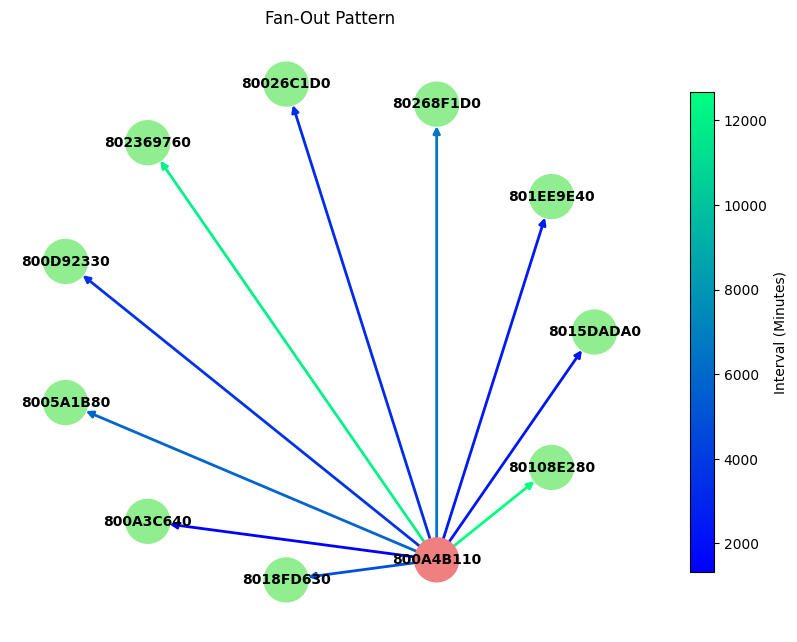

In [ ]:
fan_out('800A4B110')

### Fan-In Visualization

In [57]:
def fan_in(target):
    neighbors = list(G.predecessors(target))
    neighbors = [neighbor for neighbor in neighbors if neighbor != target]

    # Create the subgraph with the target and valid neighbors
    subgraph = G.subgraph([target] + neighbors)
    edges = [(neighbor, target) for neighbor in neighbors]
    graph = G.edge_subgraph(edges)

    # Edge color: indicate the order of transactions (interval)
    min_interval = min(d['interval'] for u, v, d in graph.edges(data=True))
    max_interval = max(d['interval'] for u, v, d in graph.edges(data=True))
    cmap = plt.cm.get_cmap('winter')  # Color map for edge coloring
    norm = mcolors.Normalize(vmin=min_interval, vmax=max_interval)
    edge_colors = [cmap(norm(d['interval'])) for u, v, d in graph.edges(data=True)]

    # Node color: highlight the source account in a different color
    node_colors = ['lightgreen' if node == target else 'lightcoral' for node in graph.nodes]

    # Visualization
    plt.figure(figsize=(8, 6))
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold', edge_color=edge_colors, width=2)

    # Edge labels for clarity (Weight and Payment Format)
    # edge_labels = {
    #     (u, v): f"Amount: {d['weight']}\nFormat: {d['payment_format']}"
    #     for u, v, d in graph.edges(data=True)
    # }
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Color bar for legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the color bar
    plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)

    plt.title(f"Fan-In Pattern")
    plt.show()


/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/2474705224.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('winter')  # Color map for edge coloring
/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/2474705224.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)


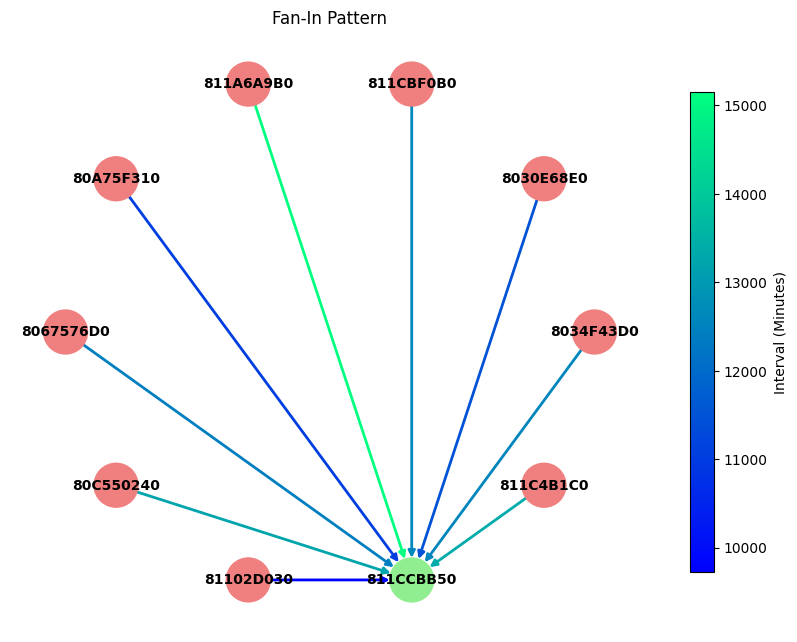

In [ ]:
fan_in('811CCBB50')

### Scatter-Gather Visualization

In [42]:
def scatter_gather(source_account, target_account):
    # Extract scatter neighbors (accounts receiving funds from the source)
    scatter_neighbors = list(G.successors(source_account))

    # Extract the relevant edges (only those connected to source and target)
    intermediary_accounts = [acc for acc in scatter_neighbors if target_account in G.successors(acc)]
    gather_edges = [(acc, target_account) for acc in intermediary_accounts]
    scatter_edges = [(source_account, acc) for acc in intermediary_accounts]

    # Combine the edges
    edges = scatter_edges + gather_edges
    graph = G.edge_subgraph(edges)

    # Set edge colors based on transaction intervals
    min_interval = min(d['interval'] for u, v, d in graph.edges(data=True))
    max_interval = max(d['interval'] for u, v, d in graph.edges(data=True))
    cmap = plt.cm.get_cmap('winter')
    norm = mcolors.Normalize(vmin=min_interval, vmax=max_interval)
    edge_colors = [cmap(norm(d['interval'])) for u, v, d in graph.edges(data=True)]

    # Node coloring: Highlight the source and target nodes
    node_colors = ['lightcoral' if node == source_account else ('lightgreen' if node == target_account else 'lightblue') 
                for node in graph.nodes]

    # Visualize the graph
    plt.figure(figsize=(12, 10))
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold', edge_color=edge_colors, width=2)

    # Edge labels for clarity
    # edge_labels = {
    #     (u, v): f"Weight: {d['weight']}\nFormat: {d['payment_format']}"
    #     for u, v, d in graph.edges(data=True)
    # }
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Color bar for legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the color bar
    plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)

    plt.title(f"Scatter-Gather Pattern")
    plt.show()

/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/339866876.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('winter')
/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/339866876.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)


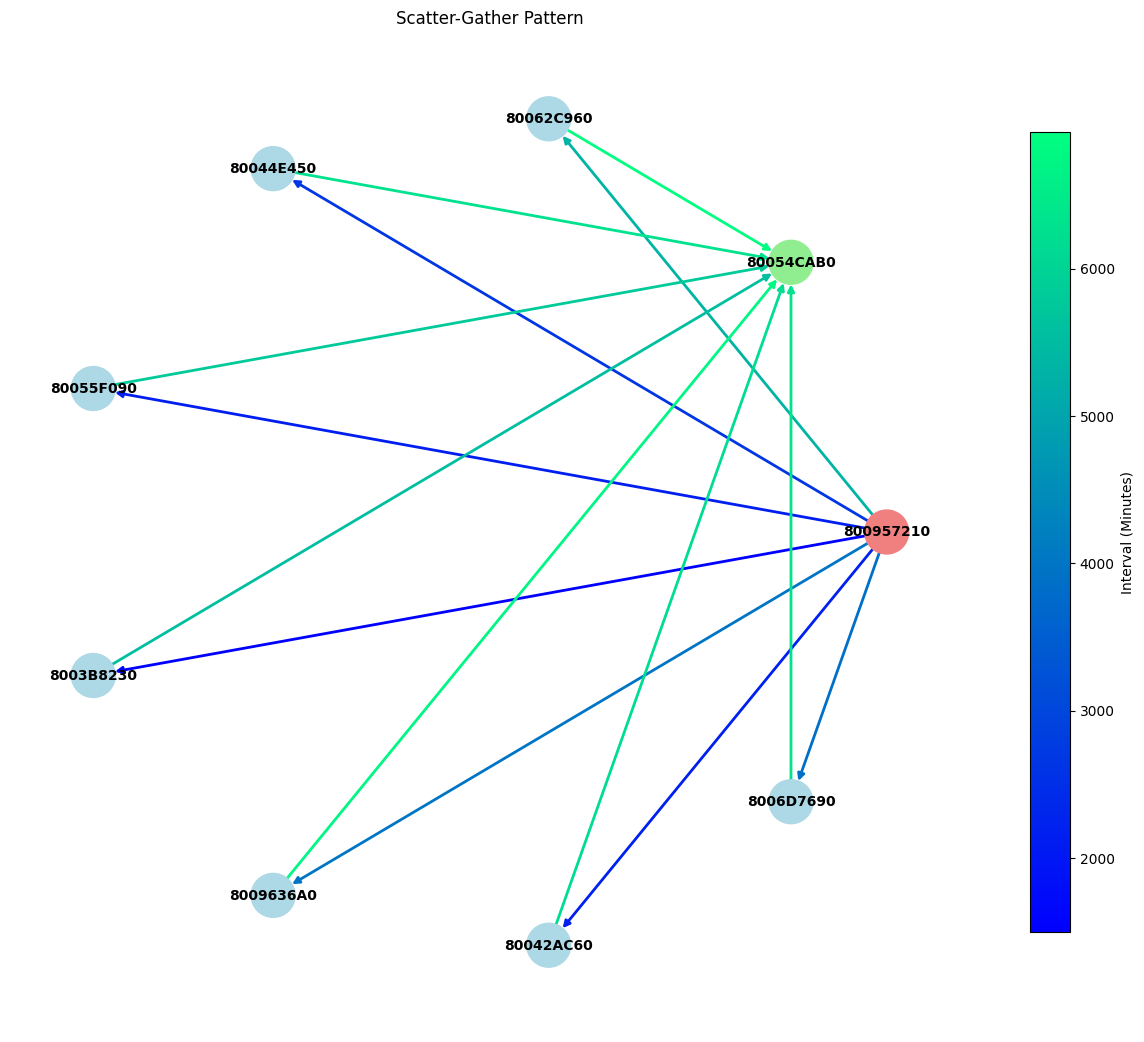

In [59]:
scatter_gather('800957210', '80054CAB0')

### Gather-Scatter

In [40]:
def gather_scatter(intermediary):
    gather_neighbors = list(G.predecessors(intermediary))
    gather_neighbors = [acc for acc in gather_neighbors if acc != intermediary]
    scatter_neighbors = list(G.successors(intermediary))
    scatter_neighbors = [acc for acc in scatter_neighbors if acc != intermediary]

    gather_edges = [(acc, intermediary) for acc in gather_neighbors]
    scatter_edges = [(intermediary, acc) for acc in scatter_neighbors]

    # Combine the edges
    edges = scatter_edges + gather_edges
    graph = G.edge_subgraph(edges)

    # Set edge colors based on transaction intervals
    min_interval = min(d['interval'] for u, v, d in graph.edges(data=True))
    max_interval = max(d['interval'] for u, v, d in graph.edges(data=True))
    cmap = plt.cm.get_cmap('winter')
    norm = mcolors.Normalize(vmin=min_interval, vmax=max_interval)
    edge_colors = [cmap(norm(d['interval'])) for u, v, d in graph.edges(data=True)]

    # Node coloring: Highlight the source and target nodes
    node_colors = ['plum' if (node in gather_neighbors and node in scatter_neighbors) else ('lightcoral' if node in gather_neighbors else ('lightgreen' if node in scatter_neighbors else 'lightblue')) 
                for node in graph.nodes]

    # Visualize the graph
    plt.figure(figsize=(12, 10))
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=10, font_weight='bold', edge_color=edge_colors, width=2)

    # Edge labels for clarity
    # edge_labels = {
    #     (u, v): f"Weight: {d['weight']}\nFormat: {d['payment_format']}"
    #     for u, v, d in graph.edges(data=True)
    # }
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    # Color bar for legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array for the color bar
    plt.colorbar(sm, label='Interval (Minutes)', shrink=0.8)

    plt.title(f"Gather-Scatter Pattern")
    plt.show()

/var/folders/q7/1xh6fjp17l728kwxlkbcrs7w0000gn/T/ipykernel_16656/1035770672.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('winter')


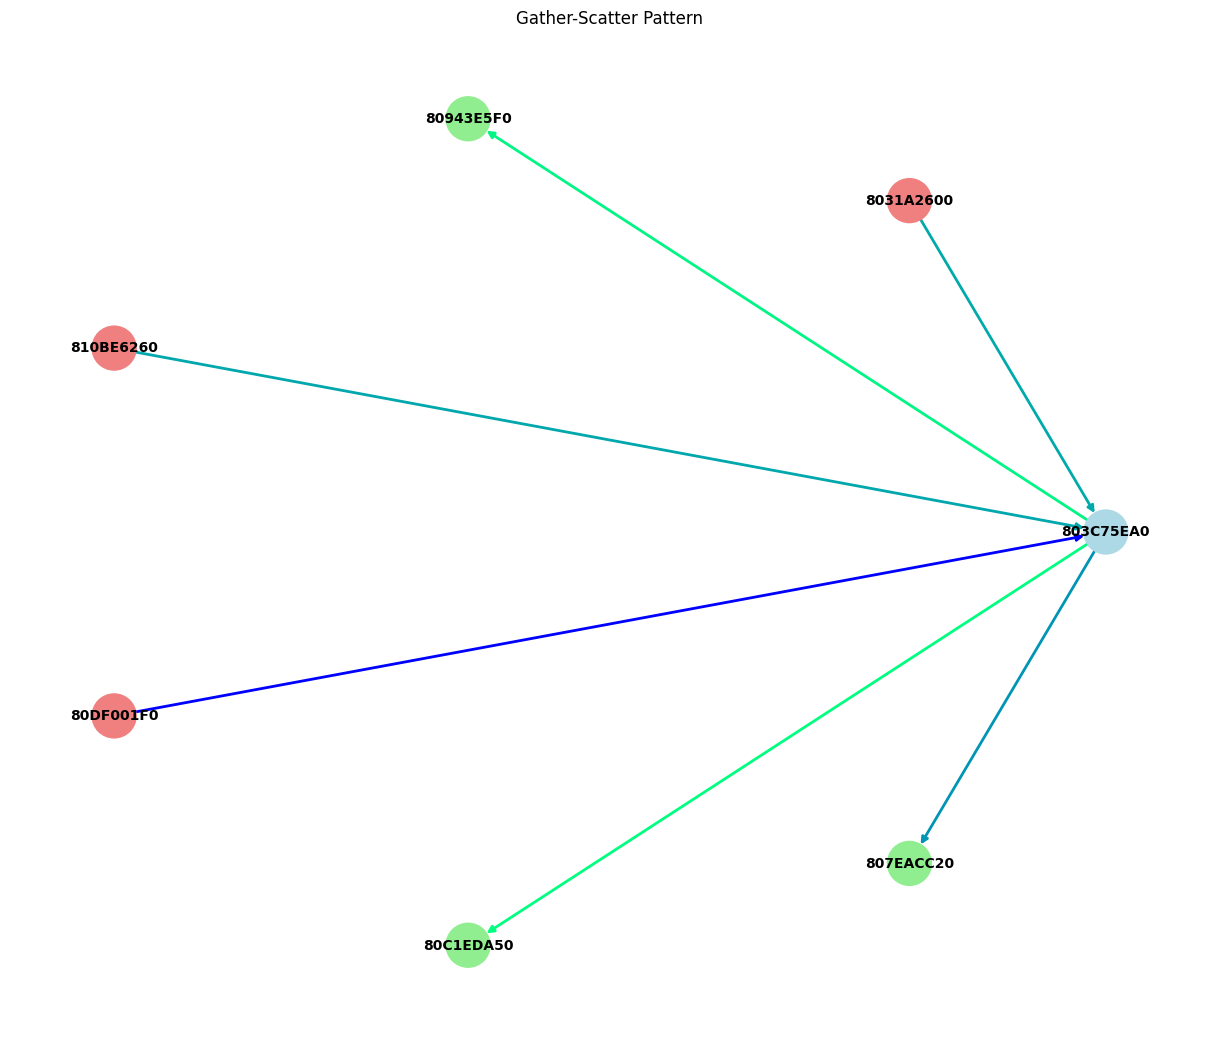

In [41]:
gather_scatter("803C75EA0")